In [6]:
%%bash
nbqa flake8 ~/Documents/earth-analytics/ea-course-notebooks/eabootcamp/in-class-notebooks/11-nwis-folium.ipynb

In [1]:
"""A notebook to download and plot Boulder-area streamflow data."""
import os
import pathlib

import folium
import hydrofunctions as hf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# There is a bug in hydrofunctions that turns off plotting in Jupyter
%matplotlib inline

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

In [2]:
# Define and create download directories
ep_downloads_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'earthpy-downloads')
nwis_download_dir = os.path.join(ep_downloads_dir, 'nwis-downloads')
if not os.path.exists(nwis_download_dir):
    os.makedirs(nwis_download_dir)

1. site `06730500` for the [Boulder Creek Station near Longmont, CO](https://waterdata.usgs.gov/nwis/inventory/?site_no=06730500) in Weld County (Northern Colorado)
2. site `09105000` for the [Plateau Creek Station near Cameo, CO](https://waterdata.usgs.gov/nwis/inventory/?site_no=09105000) in Mesa County (Western Colorado)
3. site `07106300` for the [Fountain Creek Station near Pinon, CO](https://waterdata.usgs.gov/nwis/inventory/?site_no=07106300) in Pueblo County (Central Colorado)
4. site `07126390` for the [Lockwood Canyon Creek Station near Thatcher, CO](https://waterdata.usgs.gov/co/nwis/inventory/?site_no=07126390) in Las Animas County (Southeastern Colorado)

In [20]:
def download_nwis_dv(
        site_no, download_dir, override=False,
        start_date='1990-01-01', end_date='2018-01-01'):
    """Download NWIS daily values for a given site number.

    Parameters
    ----------
    site_no
      The NWIS site number to download.

    start_date, end_date: str, date-like
      The start and end dates for the data range in YYYY-MM-DD format.

    Returns
    -------
    nwis_df: pd.DataFrame
      The requested discharge data.
    """
    nwis_filename = 'discharge-{site_no}.csv'.format(site_no=site_no)
    nwis_path = os.path.join(download_dir, nwis_filename)
    
    if (not os.path.exists(nwis_path)) or override:
        # Download discharge data and rename columns
        nwis = hf.NWIS(
            site_no, service='dv',
            start_date=start_date, end_date=end_date,
            parameterCd='00060')
        nwis_df = nwis.df('discharge')
        col_name = 'USGS:{site_no}:00060:00003'.format(site_no=site_no)
        nwis_df = nwis_df.rename(columns={col_name: 'discharge_cfs'})

        # Extract meta data and add to DataFrame
        nwis_df['site_no'] = site_no
        geoloc = hf.get_nwis_property(nwis.json, 'geoLocation')
        nwis_df['latitude'] = geoloc[0]['geogLocation']['latitude']
        nwis_df['longitude'] = geoloc[0]['geogLocation']['longitude']
        nwis_df['site_name'] = hf.get_nwis_property(nwis.json, 'siteName')[0]
        
        # Cache result
        nwis_df.to_csv(nwis_path)
    
    # Load cached result
    nwis_df = pd.read_csv(
        nwis_path, 
        index_col='datetimeUTC', 
        parse_dates=True,
        dtype={'site_no': 'str'})
    return nwis_df


# Sites near Boulder, CO
site_nos = ['06730500', '09105000', '07106300', '07126390']
discharge_dfs = []
for site_number in site_nos:
    # Download 30 years of data for study domain
    nwis_site_df = download_nwis_dv(
        site_number, nwis_download_dir)
    discharge_dfs.append(nwis_site_df)

discharge_df = pd.concat(discharge_dfs)
discharge_df

,discharge_cfs,site_no,latitude,longitude,site_name
datetimeUTC,,,,,
1990-01-01 00:00:00+00:00,62.0,06730500,40.138778,-105.020222,"BOULDER CREEK AT MOUTH NEAR LONGMONT, CO"
1990-01-02 00:00:00+00:00,62.0,06730500,40.138778,-105.020222,"BOULDER CREEK AT MOUTH NEAR LONGMONT, CO"
1990-01-03 00:00:00+00:00,64.0,06730500,40.138778,-105.020222,"BOULDER CREEK AT MOUTH NEAR LONGMONT, CO"
1990-01-04 00:00:00+00:00,54.0,06730500,40.138778,-105.020222,"BOULDER CREEK AT MOUTH NEAR LONGMONT, CO"
1990-01-05 00:00:00+00:00,54.0,06730500,40.138778,-105.020222,"BOULDER CREEK AT MOUTH NEAR LONGMONT, CO"
...,...,...,...,...,...
2017-10-27 00:00:00+00:00,0.0,07126390,37.492793,-103.828011,"LOCKWOOD CANYON CREEK NEAR THATCHER, CO"
2017-10-28 00:00:00+00:00,0.0,07126390,37.492793,-103.828011,"LOCKWOOD CANYON CREEK NEAR THATCHER, CO"
2017-10-29 00:00:00+00:00,0.0,07126390,37.492793,-103.828011,"LOCKWOOD CANYON CREEK NEAR THATCHER, CO"


In [17]:
# Another method
# Sites near Boulder, CO
site_nos = ['06730500', '09105000', '07106300', '07126390']

metadata_rows = []
for site_no in site_nos:
    # Extract meta data
    metadata_row = hf.site_file(site_no).table
    
    metadata_rows.append(metadata_row)
    

metadata_df = pd.concat(metadata_rows)
metadata_df = (
    metadata_df
    [['site_no', 'station_nm', 'dec_lat_va', 'dec_long_va']]
    .set_index('site_no'))
metadata_df

Retrieving the site file for site # 06730500  from  https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=06730500&siteOutput=expanded&siteStatus=all
Retrieving the site file for site # 09105000  from  https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=09105000&siteOutput=expanded&siteStatus=all
Retrieving the site file for site # 07106300  from  https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=07106300&siteOutput=expanded&siteStatus=all
Retrieving the site file for site # 07126390  from  https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=07126390&siteOutput=expanded&siteStatus=all


,station_nm,dec_lat_va,dec_long_va
site_no,,,
06730500,"BOULDER CREEK AT MOUTH NEAR LONGMONT, CO",40.138778,-105.020222
09105000,"PLATEAU CREEK NEAR CAMEO, CO",39.183611,-108.268333
07106300,"FOUNTAIN CREEK NEAR PINON, CO",38.429444,-104.598056
07126390,"LOCKWOOD CANYON CREEK NEAR THATCHER, CO",37.492793,-103.828011


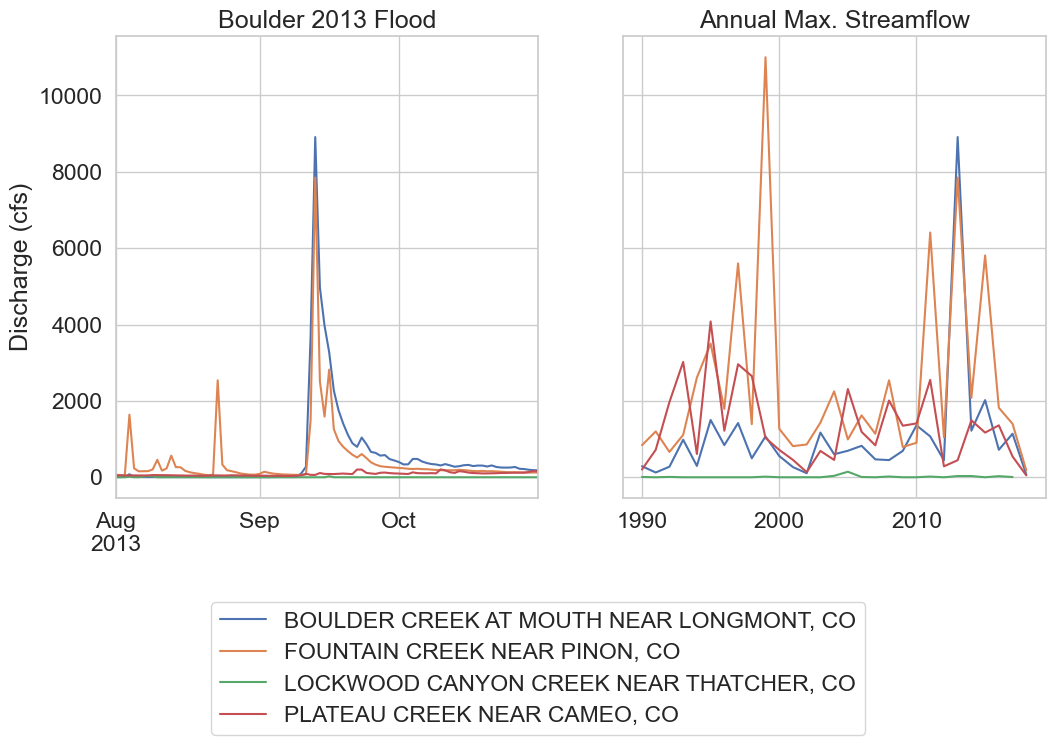

In [101]:
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

discharge_df['year'] = discharge_df.index.year
annual_max_discharge_df = (
    discharge_df
    .groupby(['year', 'site_no'])
    .max()
    .reset_index()
    .set_index('year')
    .rename(columns = {'discharge_cfs': 'annual_max_discharge_cfs'}))

for site_no, site_df in discharge_df.loc['2013-08':'2013-10'].groupby('site_no'):
    site_df.plot(
        y='discharge_cfs', 
        ax=ax_left, 
        label=site_df.site_name[0])
    
for site_no, annual_max_df in annual_max_discharge_df.groupby('site_no'):
    annual_max_df.plot(
        y='annual_max_discharge_cfs',
        ax=ax_right,
        label=annual_max_df.site_name.iloc[0],
        legend=False)

ax_left.set(xlabel='', ylabel='Discharge (cfs)', title='Boulder 2013 Flood')
ax_right.set(xlabel='', ylabel='', title='Annual Max. Streamflow')

ax_left.legend(loc='upper center', bbox_to_anchor=(1, -.2))
plt.show()

In [102]:
site_map = folium.Map(
    location=[40.0150, -105.2705],
    zoom_start=6,
    tiles='Stamen terrain')

for site_name, site_df in discharge_df.groupby('site_name'):
    (folium.Marker(
        location=[site_df.latitude.unique(), site_df.longitude.unique()],
        popup=site_name,
        icon=folium.Icon(color="red"))
     .add_to(site_map))


site_map